# Introducing Supriya

A Python API for SuperCollider

https://github.com/josiah-wolf-oberholtzer/supriya

## Supriya lets you...

- boot and communicate with SuperCollider's `scsynth` synthesis server

- construct and compile SynthDef unit generator graphs in native Python code

- build and control graphs of synthesizers and synthesizer groups

- explicitly object-model `scsynth`-specific OSC commands  via `Request` and `Response` classes

- compile non-realtime synthesis scores via Supriya's `Session` class

- write patterns for realtime or non-realtime synthesis

A lot of the same stuff you do with `sclang` and `scide`, just in Python instead.

## About the author

- A composer and programmer
  - https://github.com/josiah-wolf-oberholtzer
  - https://soundcloud.com/josiah-wolf-oberholtzer/in-the-tall-grasses

- PhD from Harvard in Music Composition, specializing in massively multi-channel tape music and symbolic computer-assisted composition

- Core contributor to Abjad (https://http://abjad.mbrsi.org/), a Python API for LilyPond

- Engineering team lead at Capital One, managing a group developing serverless machine learning applications for hotel reservation arbitrage

- Spent way too much time using and teaching Max

## Hold up, what's Python?

## OK, but why make another `scsynth` client?

## Hello World

In [1]:
from supriya import Server, Synth

In [2]:
server = Server()
server.boot()

<Server: udp://127.0.0.1:57751, 8i8o>

In [3]:
synth = Synth()
synth.allocate()

<+ Synth: 1000>

In [4]:
print(server)

NODE TREE 0 group
    1 group
        1000 default
            out: 0.0, amplitude: 0.1, frequency: 440.0, gate: 1.0, pan: 0.5


In [5]:
synth.release()

<+ Synth: 1000>

In [6]:
server.quit()

<Server: offline>

## Hello World (a little more complicated)

In [7]:
from supriya import Bus, Group, Server, Synth

In [8]:
server = Server().boot()

In [9]:
bus = Bus.control().allocate()
bus.set(0.5)

In [10]:
group = Group().allocate()
for i in range(1, 10):
    synth = Synth(amplitude=bus, frequency=111 * i)
    _ = synth.allocate(target_node=group)

In [11]:
bus.set(1)

In [12]:
group.controls["gate"] = 0

In [13]:
server.quit()

<Server: offline>

# Node and Message Aggregation

### Nodes (synths and groups) can be aggregated just like Python lists

In [14]:
synth_a = Synth(frequency=444)
synth_b = Synth(frequency=555)
synth_c = Synth(frequency=666)
inner_group = Group()
outer_group = Group()
inner_group.append(synth_b)
outer_group.extend([synth_a, inner_group, synth_c])

### Allocation, deallocation, ordering are auto-bundled

In [15]:
server = Server().boot()
_ = synth_a.synthdef.allocate()  # manual allocation

In [16]:
with server.osc_io.capture() as osc_capture:
    server.default_group.append(outer_group)  # everything allocated at once!

In [17]:
for osc_message in osc_capture.sent_messages:
    print(repr(osc_message))

OscBundle(
    contents=(
        OscMessage(21, 1000, 0, 1),
        OscMessage(9, 'default', 1001, 0, 1000, 'frequency', 444.0),
        OscMessage(21, 1002, 3, 1001),
        OscMessage(9, 'default', 1003, 0, 1002, 'frequency', 555.0),
        OscMessage(9, 'default', 1004, 3, 1002, 'frequency', 666.0),
        OscMessage(52, 0),
        ),
    )


In [18]:
print(server)

NODE TREE 0 group
    1 group
        1000 group
            1001 default
                out: 0.0, amplitude: 0.1, frequency: 444.0, gate: 1.0, pan: 0.5
            1002 group
                1003 default
                    out: 0.0, amplitude: 0.1, frequency: 555.0, gate: 1.0, pan: 0.5
            1004 default
                out: 0.0, amplitude: 0.1, frequency: 666.0, gate: 1.0, pan: 0.5


In [19]:
with server.osc_io.capture() as osc_capture:
    inner_group.extend([synth_a, synth_c])

In [20]:
for osc_message in osc_capture.sent_messages:
    print(repr(osc_message))

OscBundle(
    contents=(
        OscMessage(19, 1001, 1003),
        OscMessage(19, 1004, 1001),
        OscMessage(52, 1),
        ),
    )


### Freed subtrees do not lose their structure

In [21]:
print(server)

NODE TREE 0 group
    1 group
        1000 group
            1002 group
                1003 default
                    out: 0.0, amplitude: 0.1, frequency: 555.0, gate: 1.0, pan: 0.5
                1001 default
                    out: 0.0, amplitude: 0.1, frequency: 444.0, gate: 1.0, pan: 0.5
                1004 default
                    out: 0.0, amplitude: 0.1, frequency: 666.0, gate: 1.0, pan: 0.5


In [22]:
outer_group.free()

<- Group: ???>

In [23]:
print(outer_group)

??? group
    ??? group
        ??? default
            amplitude: 0.1, frequency: 555.0, gate: 1.0, out: 0.0, pan: 0.5
        ??? default
            amplitude: 0.1, frequency: 444.0, gate: 1.0, out: 0.0, pan: 0.5
        ??? default
            amplitude: 0.1, frequency: 666.0, gate: 1.0, out: 0.0, pan: 0.5


### Message aggregation knows about completion messages

In [24]:
synth_a.synthdef.free()  # this is really the default synthdef
with server.osc_io.capture() as osc_capture:
    outer_group.allocate()

Oh boy...

In [25]:
for osc_message in osc_capture.sent_messages:
    print(repr(osc_message))

OscMessage(5, bytearray(b'SCgf\x00\x00\x00\x02\x00\x01\x07default\x00\x00\x00\x0c\x00\x00\x00\x00>\x99\x99\x9a<#\xd7\n?333@\x00\x00\x00\xbe\xcc\xcc\xcd>\xcc\xcc\xcdEz\x00\x00E\x9c@\x00E\x1c@\x00EH\x00\x00?\x80\x00\x00\x00\x00\x00\x05\x00\x00\x00\x00=\xcc\xcc\xcdC\xdc\x00\x00?\x80\x00\x00?\x00\x00\x00\x00\x00\x00\x05\tamplitude\x00\x00\x00\x01\tfrequency\x00\x00\x00\x02\x04gate\x00\x00\x00\x03\x03out\x00\x00\x00\x00\x03pan\x00\x00\x00\x04\x00\x00\x00\x14\x07Control\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x07Control\x01\x00\x00\x00\x00\x00\x00\x00\x04\x00\x01\x01\x01\x01\x01\x06VarSaw\x02\x00\x00\x00\x03\x00\x00\x00\x01\x00\x00\x00\x00\x00\x01\x00\x00\x00\x01\xff\xff\xff\xff\x00\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x01\x02\x05Linen\x01\x00\x00\x00\x05\x00\x00\x00\x01\x00\x00\x00\x00\x00\x01\x00\x00\x00\x02\xff\xff\xff\xff\x00\x00\x00\x02\xff\xff\xff\xff\x00\x00\x00\x03\xff\xff\xff\xff\x00\x00\x00\x01\xff\xff\xff\xff\x00\x00\x00\x04\x01\x04Rand\x00\x00\x00\x00\x02\x00\x00\x00\x

In [26]:
server.quit()

<Server: offline>

## Graphing (with Graphviz)

In [27]:
%reload_ext supriya.ext.ipython

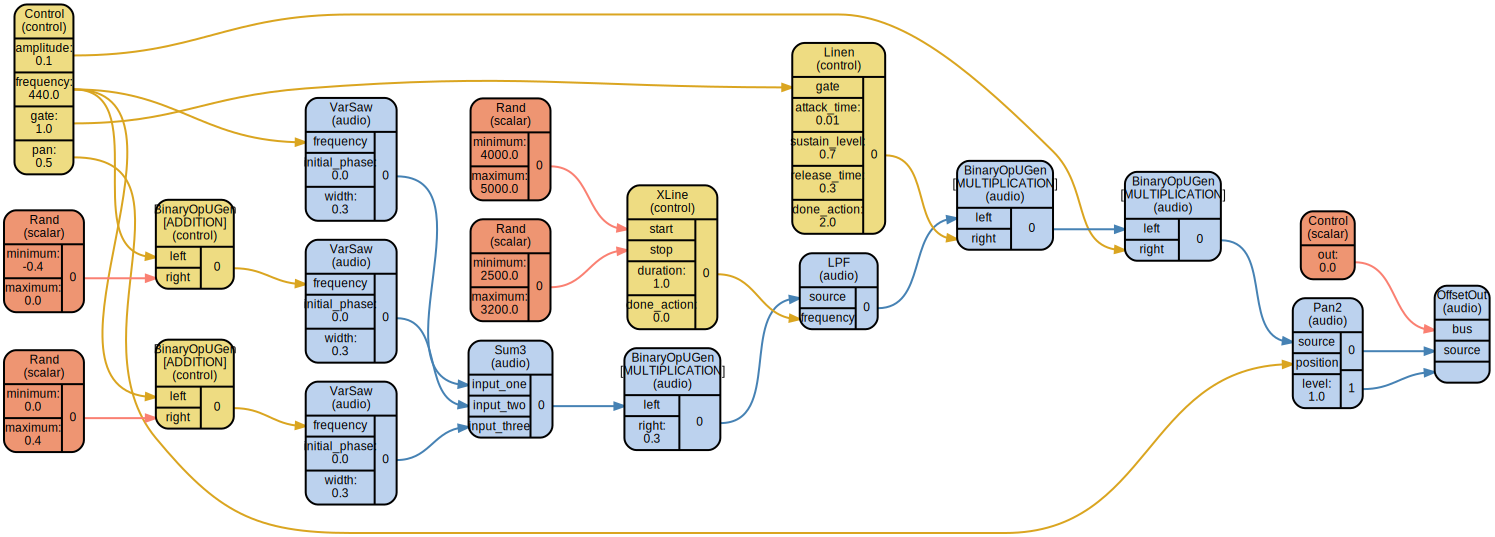

In [30]:
import supriya
_ = supriya.graph(synthdefs.default)